In [70]:
from langchain_openai import ChatOpenAI

a4f_api_key = "ddc-a4f-7bf32a74dec5465fa68c33bd2eaae66b"
a4f_base_url = "https://api.a4f.co/v1"

llm = ChatOpenAI(
    model="provider-3/gpt-4o-mini",  # or another supported model
    openai_api_key=a4f_api_key,
    openai_api_base=a4f_base_url,
)

result = llm.invoke("write a c++ code to find largest element in an array")

In [71]:
type(result)

langchain_core.messages.ai.AIMessage

In [72]:
from rich.markdown import Markdown

Markdown(result.content)

Sure! Below is a simple C++ program that finds the largest element in an array.                                    

                                                                                                                   
 #include <iostream>                                                                                               
 using namespace std;                                                                                              
                                                                                                                   
 int main() {                                                                                                      
     int n;                                                                                                        
                                                                                                                   
     // Ask the user for the number of elements in the array                                                       
     cout << "Enter the number of elements in the array: ";                                                        
     cin >> n;                                                                                                     
                                                                                                                   
     // Declare the array                                                                                          
     int arr[n];                                                                                                   
                                                                                                                   
     // Input elements into the array                                                                              
     cout << "Enter " << n << " elements:" << endl;                                                                
     for (int i = 0; i < n; i++) {                                                                                 
         cin >> arr[i];                                                                                            
     }                                                                                                             
                                                                                                                   
     // Initialize the largest variable to the first element of the array                                          
     int largest = arr[0];                                                                                         
                                                                                                                   
     // Loop through the array to find the largest element                                                         
     for (int i = 1; i < n; i++) {                                                                                 
         if (arr[i] > largest) {                                                                                   
             largest = arr[i];                                                                                     
         }                                                                                                         
     }                                                                                                             
                                                                                                                   
     // Output the largest element                                                                                 
     cout << "The largest element in the array is: " << largest << endl;                                           
                                                                                                                   
     return 0;                                         

## Tools

[Tools](https://python.langchain.com/docs/concepts/tools/) are utilities that can be called by a chat model. In LangChain, creating tools can be done using the `@tool` decorator, which transforms Python functions into callable tools. It will automatically infer the tool's name, description, and expected arguments from the function definition. You can also use [Model Context Protocol (MCP) servers](https://github.com/langchain-ai/langchain-mcp-adapters) as LangChain-compatible tools.


In [73]:
from langchain.tools import tool


@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

In [74]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [75]:
write_email.args

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

In [76]:
Markdown(write_email.description)

Write and send an email.

## Tool Calling

Tools can be [called](https://python.langchain.com/docs/concepts/tool_calling/) by LLMs. When a tool is bound to the model, the model can choose to call the tool by returning a structured output with tool arguments. We use the `bind_tools` method to augment an LLM with tools.

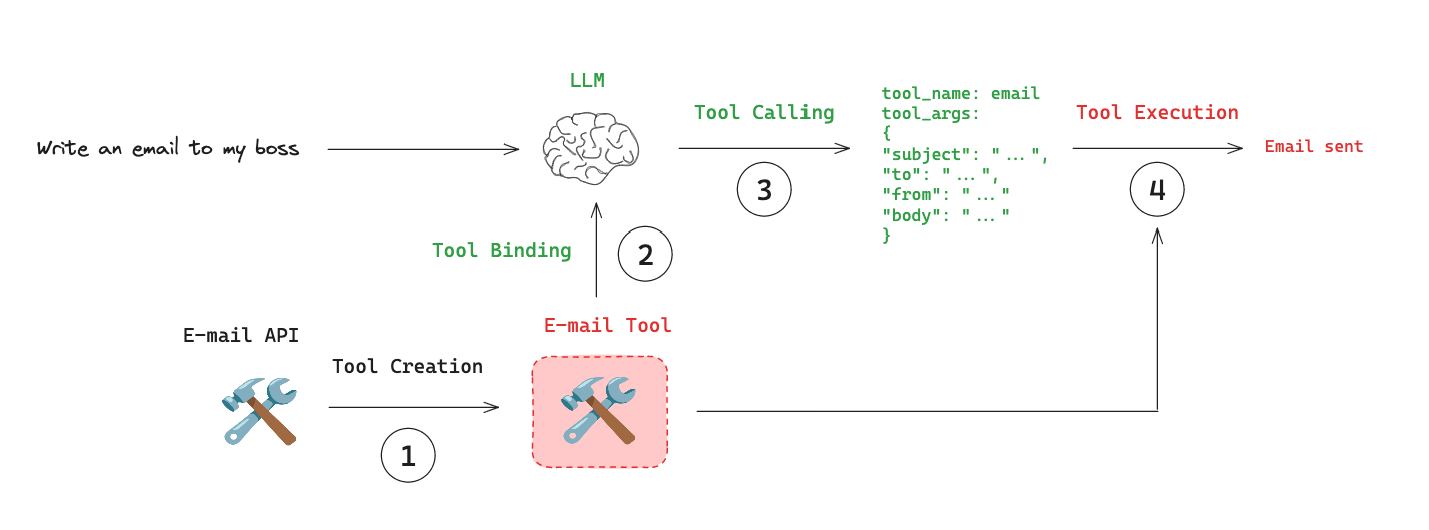

Providers often have [parameters such as `tool_choice`](https://python.langchain.com/docs/how_to/tool_choice/) to enforce calling specific tools. `any` will select at least one of the tools.

In addition, we can [set `parallel_tool_calls=False`](https://python.langchain.com/docs/how_to/tool_calling_parallel/) to ensure the model will only call one tool at a time.


In [77]:
# connect toold to a chat model
model_with_tools = llm.bind_tools(
    [write_email],
    tool_choice="auto",
    parallel_tool_calls=False,
)

# The model will now able to call tools
output = model_with_tools.invoke(
    "Draft a response to my boss (boss@pritam.corporation.com) about tommorrow's meeting"
)

In [78]:
type(output)

langchain_core.messages.ai.AIMessage

In [79]:
output

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tWXcGuBWLJJEN4q0T3qp3DDh', 'function': {'arguments': '{"to":"boss@pritam.corporation.com","subject":"Re: Tomorrow\'s Meeting","content":"Subject: Re: Tomorrow\'s Meeting\\n\\nDear [Boss\'s Name],\\n\\nThank you for the reminder about tomorrow\'s meeting. I will be prepared with the necessary materials and look forward to our discussion.\\n\\nPlease let me know if there are any specific topics you would like me to focus on.\\n\\nBest regards,\\n\\n[Your Name]"}', 'name': 'write_email'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 0, 'prompt_tokens': 29, 'total_tokens': 29, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'provider-3/gpt-4o-mini', 'system_fingerprint': None, 'id': 'ddc-a4f-chatcmpl-fc7557c3189f4668a92c56c33521e995', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ac86d1e4-4c8e-4fe8-aa47-b

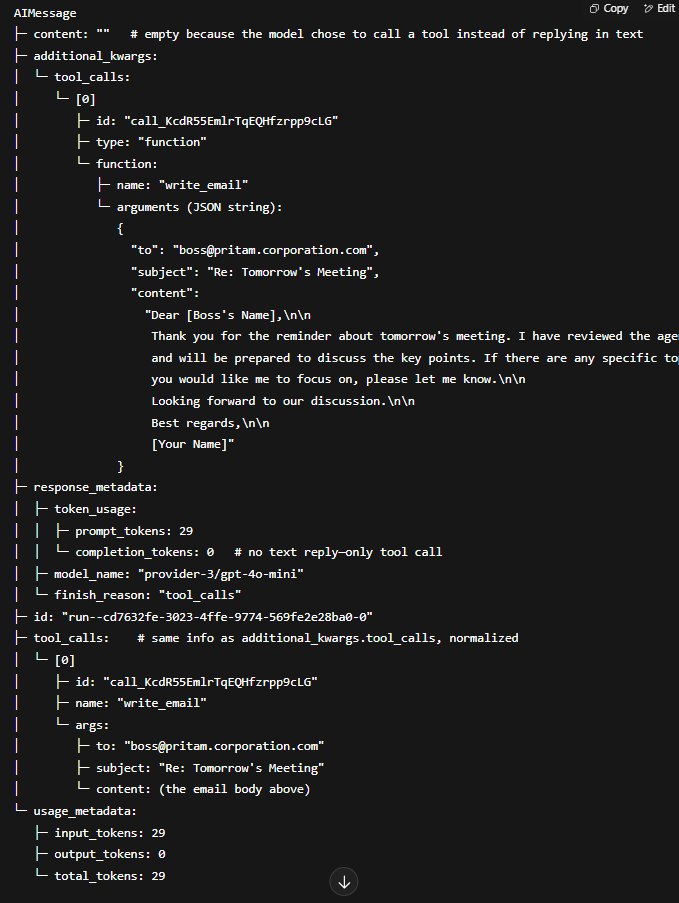


In [80]:
# extract tool calls and execute them
args = output.tool_calls[0]["args"]
args

{'to': 'boss@pritam.corporation.com',
 'subject': "Re: Tomorrow's Meeting",
 'content': "Subject: Re: Tomorrow's Meeting\n\nDear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I will be prepared with the necessary materials and look forward to our discussion.\n\nPlease let me know if there are any specific topics you would like me to focus on.\n\nBest regards,\n\n[Your Name]"}

In [81]:
# call the tool
result = write_email.invoke(args)
Markdown(result)

Email sent to boss@pritam.corporation.com with subject 'Re: Tomorrow's Meeting' and content: Subject: Re:          
Tomorrow's Meeting                                                                                                 

Dear [Boss's Name],                                                                                                

Thank you for the reminder about tomorrow's meeting. I will be prepared with the necessary materials and look      
forward to our discussion.                                                                                         

Please let me know if there are any specific topics you would like me to focus on.                                 

Best regards,                                                                                                      

[Your Name]

## Addimg LangGraph


In [82]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class StateSchema(TypedDict):
    request: str
    email: str


workflow = StateGraph(StateSchema)

In [83]:
def write_email_node(state: StateSchema) -> StateSchema:
    # Imperative code that processes the request
    output = model_with_tools.invoke(state["request"])
    args = output.tool_calls[0]["args"]
    email = write_email.invoke(args)
    return {"email": email}

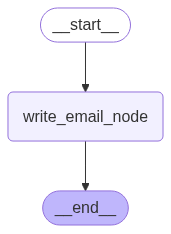

In [84]:
workflow = StateGraph(StateSchema)
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()
app

In [85]:
init_state = {
    "request": "Draft a response to my boss (email@example.com) regarding the project update.",
    "email": "",
}

result = app.invoke(init_state)
result

{'request': 'Draft a response to my boss (email@example.com) regarding the project update.',
 'email': "Email sent to email@example.com with subject 'Re: Project Update' and content: Dear [Boss's Name],\n\nThank you for your email regarding the project update. I appreciate your interest and support. \n\nI am currently finalizing the details and will ensure that all aspects are thoroughly addressed. I’ll provide a comprehensive update by [insert deadline or date]. If there are any specific areas you would like me to focus on, please let me know.\n\nBest regards,\n\n[Your Name]"}

In [86]:
email = result["email"]
Markdown(email)

Email sent to email@example.com with subject 'Re: Project Update' and content: Dear [Boss's Name],                 

Thank you for your email regarding the project update. I appreciate your interest and support.                     

I am currently finalizing the details and will ensure that all aspects are thoroughly addressed. I’ll provide a    
comprehensive update by [insert deadline or date]. If there are any specific areas you would like me to focus on,  
please let me know.                                                                                                

Best regards,                                                                                                      

[Your Name]

## Conditional Routing


In [87]:
from typing import Literal
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage


def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""
    output = model_with_tools.invoke(state["messages"])
    return {"messages": [output]}


# state["messages"] gives you the current conversation history, which you pass to the LLM for context. The LLM returns a new message, which you then wrap in a list and return as the new state.

In [88]:
def run_tool(state: MessagesState) -> MessagesState:
    """Perform the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append(
            ToolMessage(
                content=observation,  # tool output
                tool_call_id=tool_call["id"],  # must pass the same id from assistant
            )
        )

    return {"messages": result}

In [89]:
def should_continue(state: MessagesState) -> Literal["run_tool", "__end__"]:
    """Route to tool handler, or end if Done tool called"""
    messages = state["messages"]
    last_message = messages[-1]
    print("Last message:", last_message)
    if last_message.tool_calls:
        print("Routing to run_tool")
        return "run_tool"
    print("Routing to END")
    return END

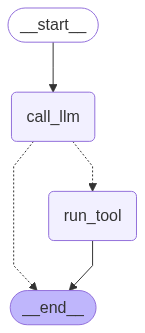

In [90]:
workflow = StateGraph(MessagesState)

workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)

workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges(
    "call_llm", should_continue, {"run_tool": "run_tool", END: END}
)
workflow.add_edge("run_tool", END)

# Run the workflow
app = workflow.compile()
app

In [91]:
result = app.invoke(
    {
        "messages": [
            HumanMessage(
                content="Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"
            )
        ]
    }
)
for m in result["messages"]:
    m.pretty_print()

Last message: content='' additional_kwargs={'tool_calls': [{'id': 'call_TBHvoc9UhjfXGjTuHeOEAGky', 'function': {'arguments': '{"to":"boss@company.ai","subject":"Confirmation of Attendance at Interrupt!","content":"Dear [Boss\'s Name],\\n\\nI hope this message finds you well. I am writing to confirm my attendance at Interrupt! I am looking forward to the opportunity and believe it will be beneficial for our work.\\n\\nThank you for considering me for this event.\\n\\nBest regards,\\n\\n[Your Name]"}', 'name': 'write_email'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 0, 'prompt_tokens': 27, 'total_tokens': 27, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'provider-3/gpt-4o-mini', 'system_fingerprint': None, 'id': 'ddc-a4f-chatcmpl-d45a8b67588d43c4b0d1a7d4feee1386', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None} id='run--caf29b95-bdf1-48a9-aa98-09288acbfd29-0' tool_calls=[{'nam

---

## Persistence

#### Threads

It can be very useful to allow agents to pause during long running tasks.

LangGraph has a built-in persistence layer, implemented through checkpointers, to enable this.

When you compile graph with a checkpointer, the checkpointer saves a [checkpoint](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints) of the graph state at every step.

Checkpoints are saved to a thread, which can be accessed after graph execution completes.

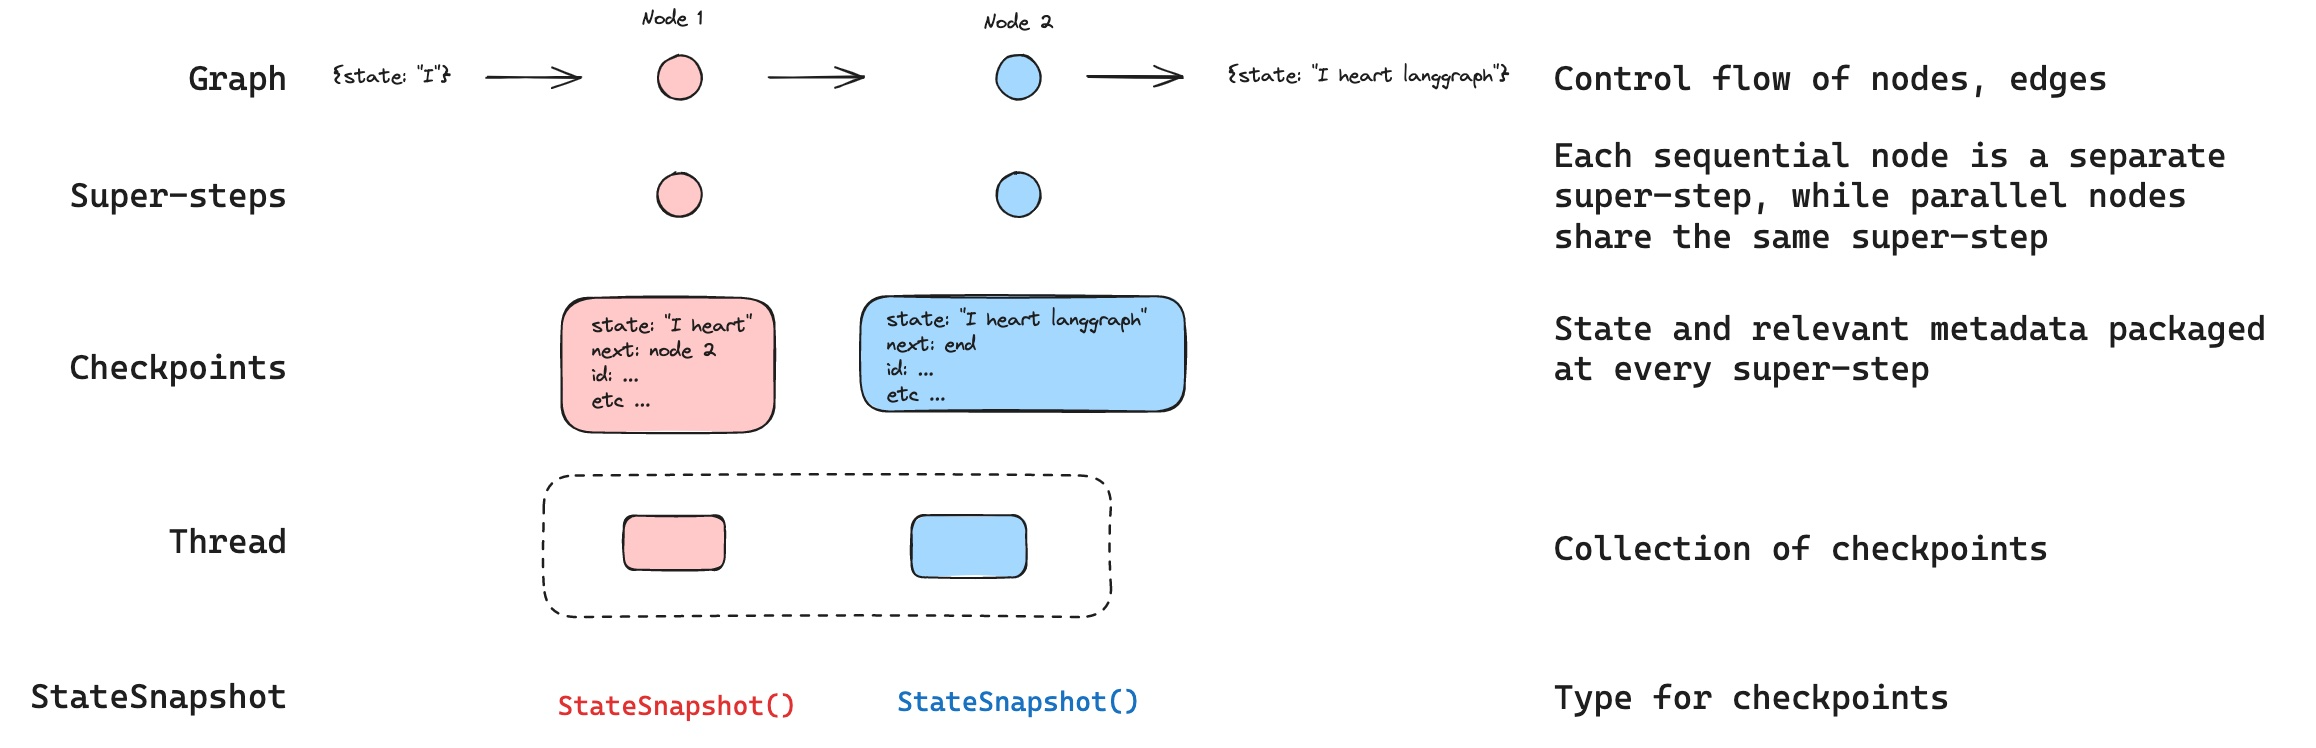

We compile the graph with a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries).


In [92]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent
import uuid

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond the user's request using the provided tools.",
    checkpointer=InMemorySaver(),
)

thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

result = agent.invoke(
    {
        "messages": [
            HumanMessage(content="what are some good practices for writing emails?")
        ]
    },
    config,
)

In [93]:
state = agent.get_state(config=config)
for message in state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

what are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Clear Subject Line**: Use a concise and relevant subject line that summarizes the content of your email.

2. **Professional Greeting**: Start with a polite greeting, such as "Dear [Name]" or "Hello [Name]".

3. **Be Concise**: Get to the point quickly. Use short paragraphs and bullet points to make the email easy to read.

4. **Use a Professional Tone**: Keep your language formal and respectful, especially in professional emails.

5. **Structure Your Content**: Organize your email with a clear introduction, body, and conclusion. This helps the reader follow your message.

6. **Be Mindful of Your Audience**: Tailor your language and content to suit the recipient. Consider their background and relationship to you.


## Interrupts

In LangGraph, we can also use [interrupts](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/) to stop graph execution at specific points.

Often this is used to collect input from a user and continue execution with collected input.


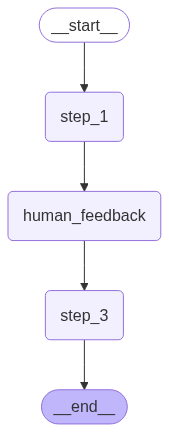

In [94]:
from typing_extensions import TypedDict
from pprint import pprint
from langgraph.graph import StateGraph, START, END

from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = InMemorySaver()

# Add
graph = builder.compile(checkpointer=memory)
graph

In [95]:
# Input
initial_input = {"input": "hello world"}

thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, config, stream_mode="updates"):
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback:', id='92f35660fdf2b826d968ad1ac00ef775'),)}




To resume from an interrupt, we can use [the `Command` object](https://langchain-ai.github.io/langgraph/how-tos/command/).

We'll use it to resume the graph from the interrupted state, passing the value to return from the interrupt call to `resume`.


In [96]:
# continue the graph execution
for event in graph.stream(
  Command(resume="go to step_3"),
  config,
  stream_mode="updates"
):
  pprint(event)
  print("\n")

---human_feedback---
{'human_feedback': {'user_feedback': 'go to step_3'}}


---Step 3---
{'step_3': None}




### Tracing

When we are using LangChain or LangGraph, LangSmith logging [will work out of the box](https://docs.smith.langchain.com/observability/how_to_guides/trace_with_langgraph) with the following environment variables set:

```
export LANGSMITH_TRACING=true
export LANGSMITH_API_KEY="<your-langsmith-api-key>"
```

---
### Deployment

We can also deploy our graph using [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/). 

This creates a server [with an API](https://langchain-ai.github.io/langgraph/cloud/reference/api/api_ref.html) that we can use to interact with our graph and an interactive IDE, LangGraph [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/).

We simply need to ensure our project has [a structure](https://langchain-ai.github.io/langgraph/concepts/application_structure/) like this:

```
my-app/
├── src/email_assistant # all project code lies within here
│   └── langgraph101.py # code for constructing your graph
├── .env # environment variables
├── langgraph.json  # configuration file for LangGraph
└── pyproject.toml # dependencies for your project
```

The `langgraph.json` file specifies the dependencies, graphs, environment variables, and other settings required to start a LangGraph server.

To test this, let's deploy `langgraph_101.py`. We have it in our `langgraph.json` file in this repo:

```
 "langgraph101": "./src/email_assistant/langgraph_101.py:app",
```

For LangGraph Platform, there are a range of [deployment options](https://langchain-ai.github.io/langgraph/tutorials/deployment/): 
 
* Local deployments can be started with `langgraph dev` from the root directory of the repo. Checkpoints are saved to the local filesystem.
* There are also various [self-hosted options](https://langchain-ai.github.io/langgraph/tutorials/deployment/#other-deployment-options). 
* For hosted deployments, checkpoints are saved to Postgres using a postgres [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries). 

Test: 
```
Draft a response to my boss (boss@company.ai) confirming that I want to attent Interrupt!
```